In [37]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import osmnx
import folium
import networkx as nx
import matplotlib.pyplot as plt
import spaghetti
from sklearn.cluster import KMeans
from esda import moran
from splot import esda


In [38]:
df = pd.read_csv('data/13-19traffic.csv')
df.head()

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,...,Accident Fields_Reference Number,1st Road Class & No,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No,Unnamed: 11,Unnamed: 15,Expr1
0,21G0539,427798,426248,5,16-Jan-15,1205,A,Snow,Daylight: street lights present,Snowing without high winds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21G0539,427798,426248,5,16-Jan-15,1205,A,Snow,Daylight: street lights present,Snowing without high winds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21G1108,431142,430087,1,16-Jan-15,1732,Unclassified,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21H0565,434602,436699,2,17-Jan-15,930,Unclassified,Dry,Daylight: street lights present,Fine without high winds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21H0638,434254,434318,2,17-Jan-15,1315,A,Wet / Damp,Daylight: street lights present,Fine without high winds,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16284 entries, 0 to 16283
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Reference Number                  14289 non-null  object 
 1   Grid Ref: Easting                 16284 non-null  int64  
 2   Grid Ref: Northing                16284 non-null  int64  
 3   Number of Vehicles                16284 non-null  int64  
 4   Accident Date                     16284 non-null  object 
 5   Time (24hr)                       16284 non-null  int64  
 6   1st Road Class                    14081 non-null  object 
 7   Road Surface                      16283 non-null  object 
 8   Lighting Conditions               16284 non-null  object 
 9   Weather Conditions                16284 non-null  object 
 10  Casualty Class                    16284 non-null  object 
 11  Casualty Severity                 16284 non-null  object 
 12  Sex 

In [40]:
traffic = df[['Grid Ref: Easting', 'Grid Ref: Northing']].rename(columns={'Grid Ref: Easting': 'Easting', 'Grid Ref: Northing': 'Northing'})
traffic.dropna(inplace=True)

In [41]:
rtc_point = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(traffic['Easting'], traffic['Northing'])])
rtc_point.set_crs(epsg=27700, inplace=True)
rtc_point

,geometry
0,POINT (427798.000 426248.000)
1,POINT (427798.000 426248.000)
2,POINT (431142.000 430087.000)
3,POINT (434602.000 436699.000)
4,POINT (434254.000 434318.000)
...,...
16279,POINT (442094.000 434619.000)
16280,POINT (423019.000 437653.000)
16281,POINT (436853.000 442515.000)
16282,POINT (421466.000 433999.000)


/Users/jiang/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


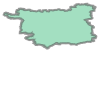

In [42]:
leeds_area = osmnx.geocode_to_gdf('Leeds, United Kingdom', buffer_dist = 10)
leeds_polygon = leeds_area['geometry'][0]
leeds_polygon

<Figure size 576x432 with 0 Axes>

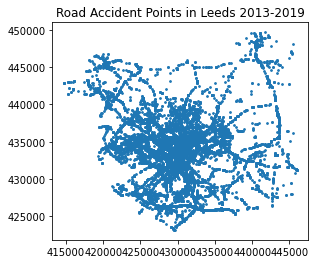

In [43]:
plt.figure(figsize=(8,6))
rtc_point.plot(markersize=3)
plt.title('Road Accident Points in Leeds 2013-2019')
# plt.savefig('fig/roadaccident.png', dpi=200)
plt.show()

In [44]:
X = traffic[['Easting', 'Northing']].to_numpy()     # the coordinates of all the traffic accidnets in Leeds
km = KMeans(n_clusters=20, random_state=0).fit(X)   # Kmeans clustering
centers = gpd.GeoDataFrame(geometry=[Point(xy) for xy in km.cluster_centers_])  # clustering centers
buffer = centers.buffer(500, cap_style=3)   # draw a square buffer of 1 km2 to each clustering center
buffer.set_crs(epsg=27700, inplace=True)
cnt = buffer.apply(lambda x: np.sum(rtc_point.within(x)))   # count the accident points within each buffer
buffer = buffer.to_crs(epsg=4326)
poly = buffer[cnt.idxmax()]     # select the buffer with the most accident points
print(f'The selected area has {max(cnt)} traffic accident points')
# print(poly)
graph = osmnx.graph_from_polygon(poly, network_type='drive')    # create a driving network using osmnx

The selected area has 538 traffic accident points


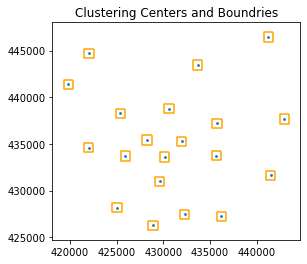

In [45]:
fig, ax = plt.subplots()
buffer = buffer.to_crs(epsg=27700)
buffer.boundary.plot(ax=ax, color='orange')
centers.plot(ax=ax, markersize=3)
ax.set_title('Clustering Centers and Boundries')
plt.savefig('fig/clustering.png', dpi=200)
plt.show()

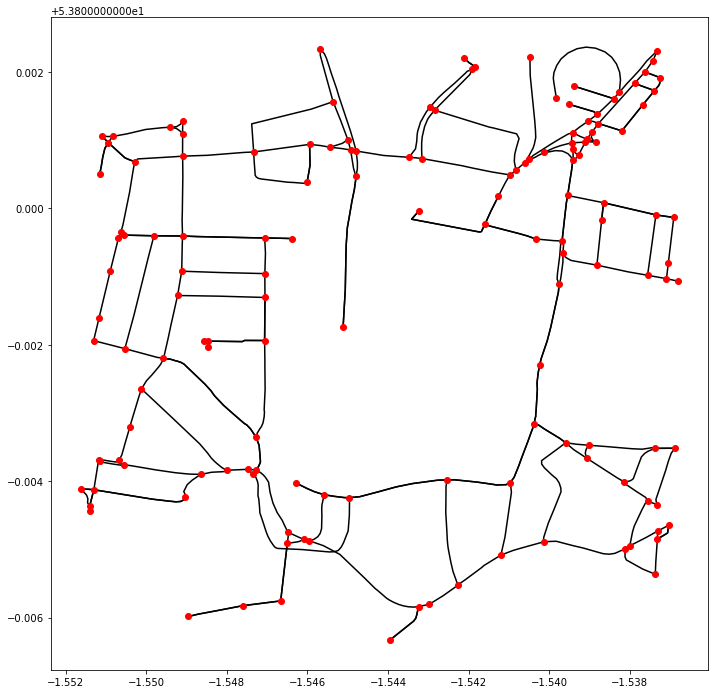

In [46]:
gdf_nodes, gdf_edges = osmnx.graph_to_gdfs(graph, nodes=True, edges=True)
base_network = gdf_edges.plot(color="k", zorder=0, figsize =(12, 12))
gdf_nodes.plot(ax=base_network, color="r", zorder=2)
plt.show()

In [47]:
# simplified_graph = osmnx.consolidate_intersections(osmnx.project_graph(graph, to_crs='epsg:27700'), tolerance=5, dead_ends=True, rebuild_graph=True)
# gdf_nodes, gdf_edges = osmnx.graph_to_gdfs(simplified_graph, nodes=True, edges=True)
# base_network = gdf_edges.plot(color="k", zorder=0, figsize =(12, 12))
# gdf_nodes.plot(ax=base_network, color="r", zorder=2)
# plt.show()

In [48]:
is_planar, counterexample = nx.check_planarity(graph, counterexample=True)
print(is_planar)

True


In [49]:
stats_dict = osmnx.basic_stats(graph)
print(' is planar: {}\n number of edges: {}\n number of nodes: {}\n averge node degree: {}\n average edge length: {}\n total edge length: {}\n average street length: {}\n total street length: {}'
.format(is_planar, stats_dict['m'], stats_dict['n'], stats_dict['k_avg'], stats_dict['edge_length_avg'], stats_dict['edge_length_total'], stats_dict['street_length_avg'], stats_dict['street_length_total']))

 is planar: True
 number of edges: 248
 number of nodes: 146
 averge node degree: 3.3972602739726026
 average edge length: 64.03049596774191
 total edge length: 15879.562999999993
 average street length: 63.55303571428568
 total street length: 12456.394999999993


In [50]:
# osmnx.plot_graph_folium(graph, zoom=13)

In [51]:
m = folium.Map([53.801277, -1.548567], zoom_start=13, tiles='cartodbpositron')
sim_geo = gpd.GeoSeries(poly).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)
m

In [52]:
# Some edges are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(graph, 'x')
y_values = nx.get_node_attributes(graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

In [53]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_gdf = gpd.GeoDataFrame(pd.DataFrame(road_lines), crs='epsg:4326')
roads_gdf  = roads_gdf.to_crs(epsg=27700)
roads_gdf

,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,access,tunnel,bridge
0,4371981,True,2,The Calls,tertiary,30 mph,136.093,"LINESTRING (430523.399 433285.608, 430506.978 ...",NaN,NaN,NaN
1,"[778025025, 759443481, 4372316]",True,1,The Calls,residential,20 mph,71.118,"LINESTRING (430523.399 433285.608, 430523.815 ...",NaN,NaN,NaN
2,4371981,True,2,The Calls,tertiary,30 mph,73.871,"LINESTRING (430391.157 433296.566, 430354.848 ...",NaN,NaN,NaN
3,"[5945489, 4372123]",True,NaN,"[Crown Street, Call Lane]",unclassified,20 mph,198.459,"LINESTRING (430391.157 433296.566, 430390.235 ...",NaN,NaN,NaN
4,38633274,True,2,The Calls,tertiary,30 mph,85.619,"LINESTRING (430320.585 433274.268, 430293.160 ...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
243,648548332,False,2,York Street,tertiary,20 mph,32.100,"LINESTRING (430571.807 433450.092, 430589.321 ...",NaN,NaN,NaN
244,854772023,False,2,The Headrow,unclassified,20 mph,45.203,"LINESTRING (429976.330 433788.597, 429964.821 ...",destination,NaN,NaN
245,28842828,True,1,Park Row,tertiary,20 mph,58.257,"LINESTRING (429931.002 433789.376, 429932.407 ...",destination,NaN,NaN
246,854772023,False,2,The Headrow,unclassified,20 mph,45.203,"LINESTRING (429931.002 433789.376, 429946.884 ...",destination,NaN,NaN


<Figure size 432x288 with 0 Axes>

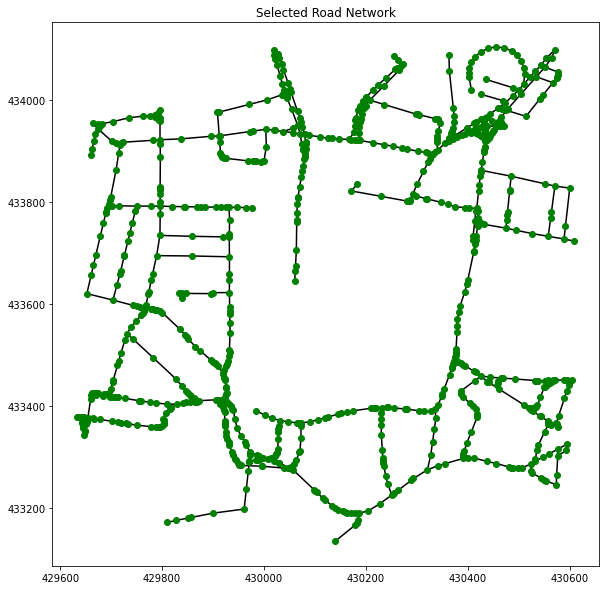

In [54]:
point_graph = spaghetti.Network(in_data=roads_gdf)
point_graph.extractgraph()
nodes_df, edges_df = spaghetti.element_as_gdf(point_graph, vertices=True, arcs=True)
plt.figure()
base_network = edges_df.plot(color='k', zorder=0, figsize=(10, 10))
nodes_df.plot(ax=base_network, color='g', zorder=2)
plt.title('Selected Road Network')
plt.savefig('fig/selectednetwork.png', dpi=200)
plt.show()

<Figure size 432x288 with 0 Axes>

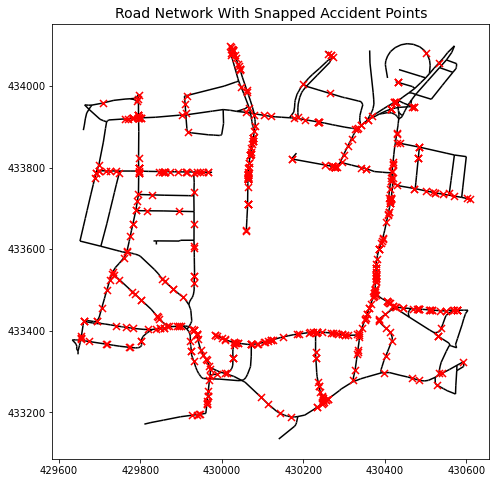

In [55]:
# change crs to 4326 and filter accident points that fall within the selected area
zone_point = rtc_point.to_crs(epsg=4326)
zone_point = zone_point.loc[zone_point.within(poly)]
# change crs to 27700 and snap accident points to arcs
zone_point = zone_point.to_crs(epsg=27700)
point_graph.snapobservations(zone_point, 'accidents')

# plotting
plt.figure()
base_network = edges_df.plot(color='k', zorder=0, figsize=(10, 8))
snapped_accidents = spaghetti.element_as_gdf(point_graph, pp_name='accidents', snapped=True)
snapped_accidents.plot(color='r', marker='x', markersize=50, zorder=1, ax=base_network)
plt.title('Road Network With Snapped Accident Points', fontsize=14)
plt.savefig('fig/sanpped.png', dpi=200)
plt.show()

<Figure size 432x288 with 0 Axes>

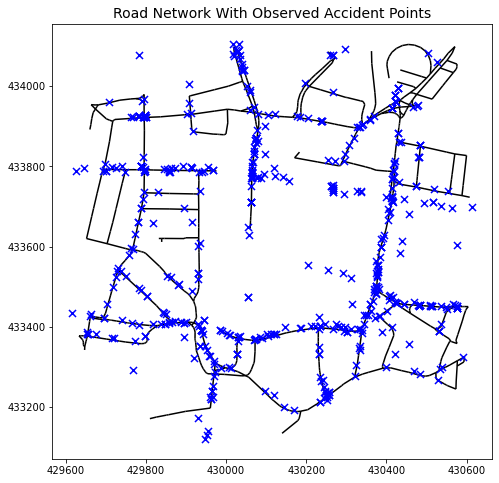

In [56]:
plt.figure()
base_network = edges_df.plot(color="k", zorder=0, figsize =(10, 8))
observed_accidents = spaghetti.element_as_gdf(point_graph, pp_name='accidents', snapped=False)
# zone_point.plot(color="b", marker="x", markersize=50, zorder=1, ax=base_network)
observed_accidents.plot(color="b", marker="x", markersize=50, zorder=1, ax=base_network)
plt.title('Road Network With Observed Accident Points', fontsize=14)
plt.savefig('fig/observed.png', dpi=200)
plt.show()

In [57]:
kres = point_graph.GlobalAutoK(point_graph.pointpatterns['accidents'], nsteps=100)
print(kres.lam)

0.04311483078830482


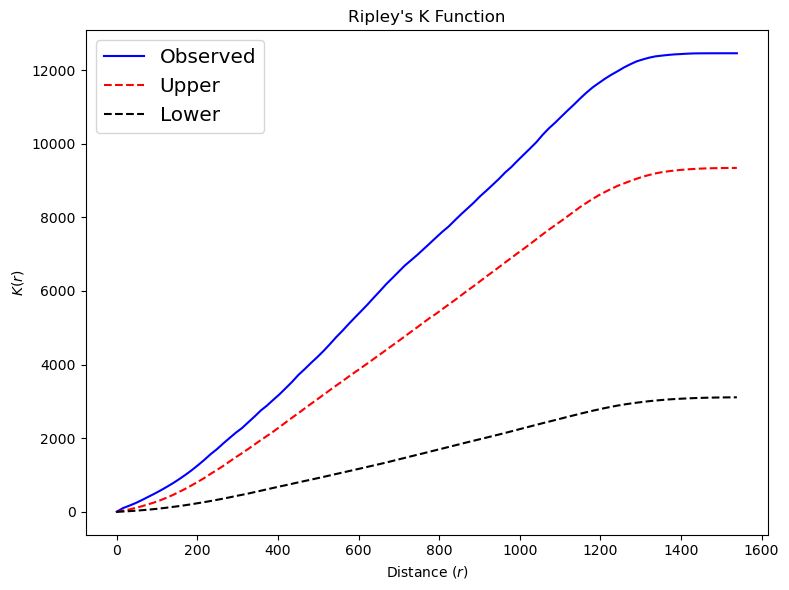

In [58]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")
ax.set_title('Ripley\'s K Function')
fig.tight_layout()
plt.savefig('fig/kfunc.png', dpi=200)

In [59]:
pointpat = point_graph.pointpatterns['accidents']   # point pattern of traffic accidens
# count the number of accident points in each arc
count_by_edge = point_graph.count_per_link(pointpat.obs_to_arc, graph=False)
weights = point_graph.w_network    # weight of the arcs in the network
edges = weights.neighbors.keys()
values = [count_by_edge[edge] if edge in count_by_edge.keys() else 0 for _, edge in enumerate(edges)]
mor = moran.Moran(values, weights)     # calculate global moran's I
print(f'Global Moran\'s I: {mor.I}')
print(f'P value: {mor.p_sim}')
print(f'Expected Moran\'s I under null hypothesis: {mor.EI}')
print(f'Z score: {mor.z_sim}')

Global Moran's I: 0.17469920293233152
P value: 0.001
Expected Moran's I under null hypothesis: -0.0011350737797956867
Z score: 5.446862758160374


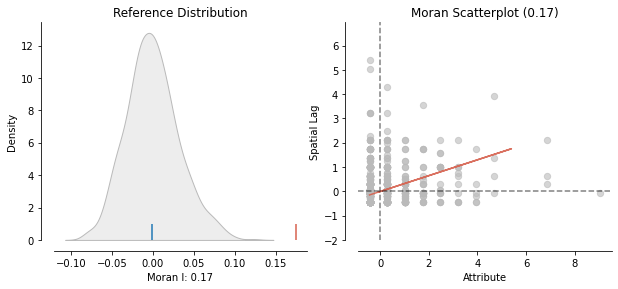

In [60]:
fig, ax = esda.plot_moran(mor, zstandard=True, figsize=(10,4))
plt.savefig('fig/globalmoran.png', dpi=200)
plt.show()

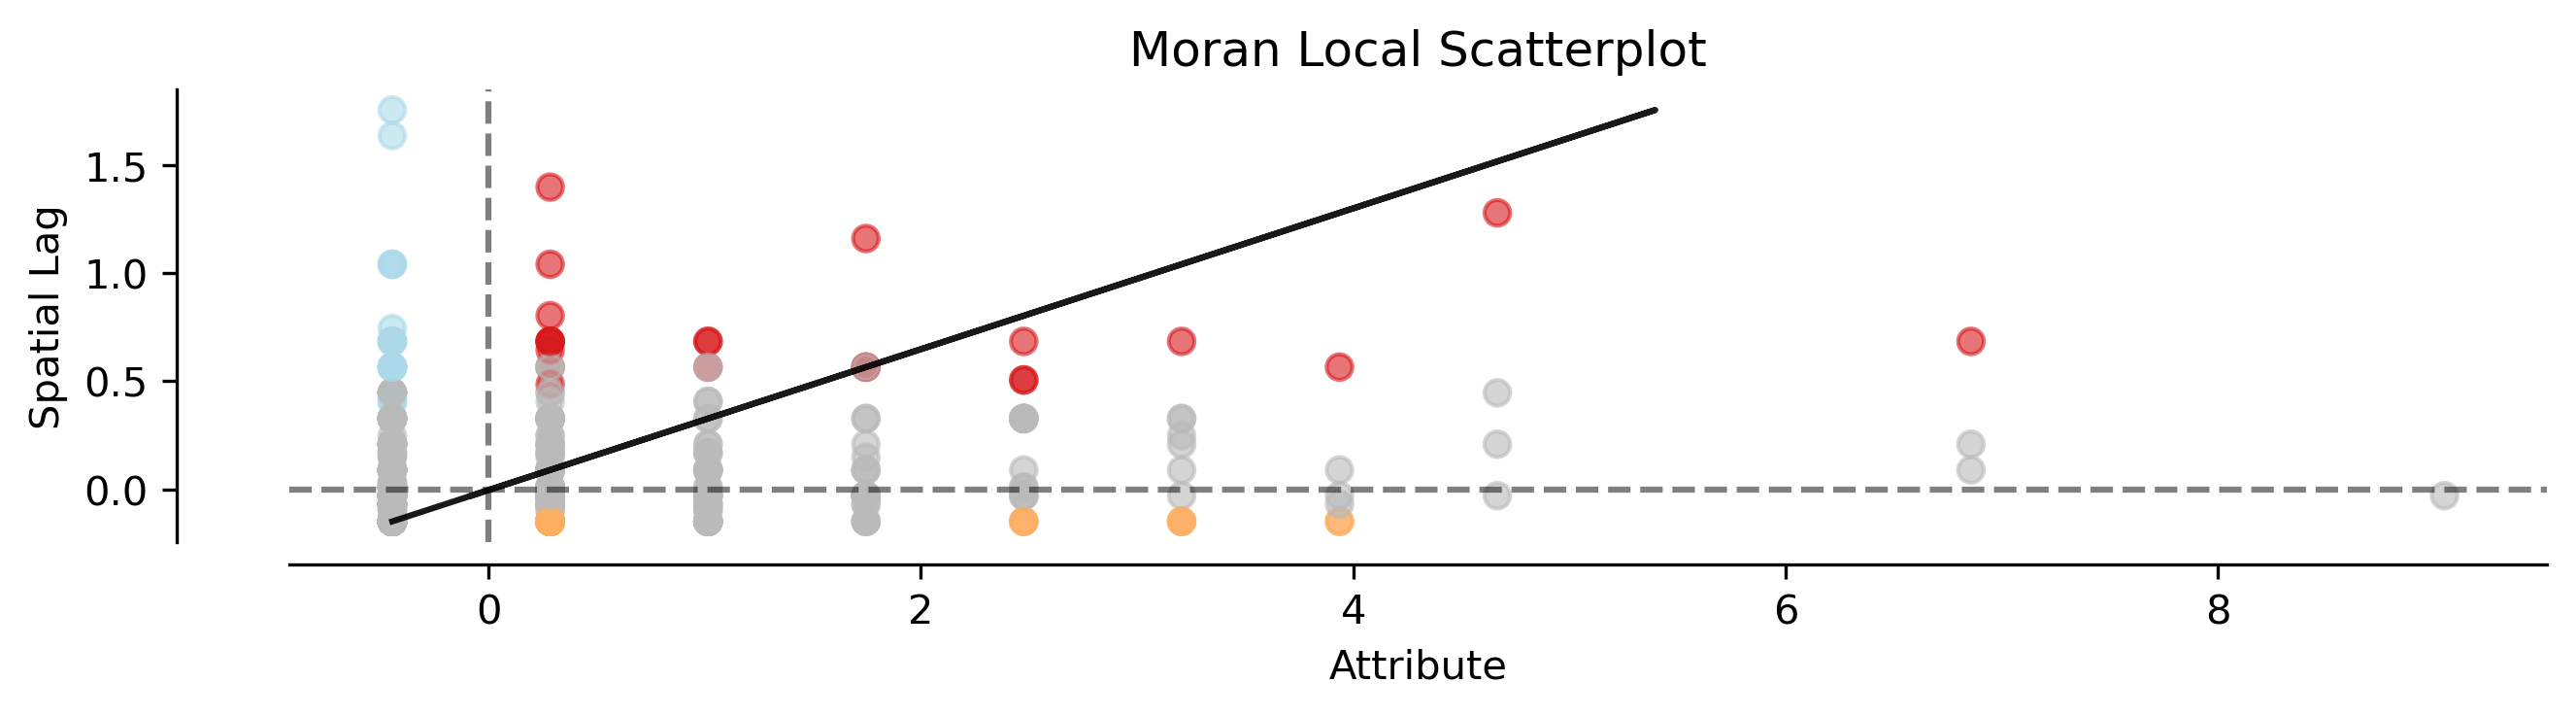

In [61]:
mor_local = moran.Moran_Local(values, weights)
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
esda.moran_scatterplot(mor_local, p=0.05, ax=ax)
plt.savefig('fig/localmoran.png', dpi=300)
plt.show()

In [62]:
print(sum(mor_local.Is))
print(sum(mor_local.EI))

153.90999778338391
-1.001135073779814


In [63]:
edges = point_graph.edges   # road edges
points = snapped_accidents.geometry.to_numpy()  # accident points
min_dist = np.full(len(points), np.inf) # store the min distance of each accident point
frac = np.zeros(len(points)) # store the fraction of length
# for each accident point, calculate the distance to all the edge point
# find the min dist as the dist to the nearest intersection
for i in range(len(points)):
    x = points[i].x
    y = points[i].y
    for edg in edges:
        dist = list(point_graph.compute_distance_to_vertices(x, y, edg))
        if min(dist) < min_dist[i]:
            min_dist[i] = min(dist)
            frac[i] = min(dist)/sum(dist)   # calculate fraction

print(f'mean distance to the nearest intersection: {np.mean(min_dist)}')
print(f'median distance to the nearest intersection: {np.median(min_dist)}')
print(f'mean fraction of the road length: {np.mean(frac)}')
        

mean distance to the nearest intersection: 29.62025862191109
median distance to the nearest intersection: 19.86143572991911
mean fraction of the road length: 0.20647227003650187


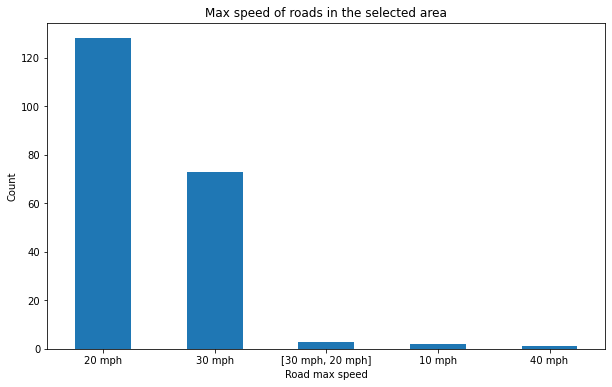

In [64]:
plt.figure(figsize=(10,6))
roads_gdf['maxspeed'].value_counts().plot(kind='bar', ylabel='Count', xlabel='Road max speed')
plt.xticks(rotation=0)
plt.title('Max speed of roads in the selected area')
plt.savefig('fig/maxspeed.png', dpi=200)
plt.show()

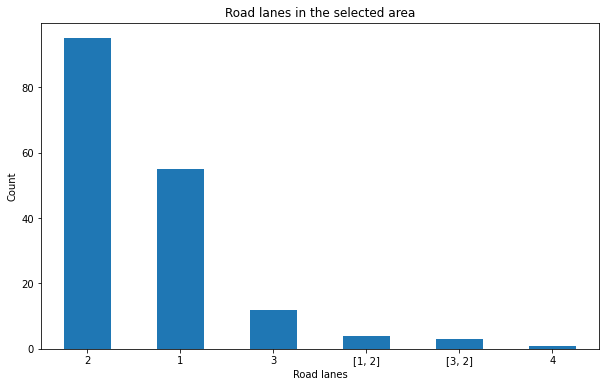

In [65]:
plt.figure(figsize=(10,6))
roads_gdf['lanes'].value_counts().plot(kind='bar', ylabel='Count', xlabel='Road lanes')
plt.xticks(rotation=0)
plt.title('Road lanes in the selected area')
plt.savefig('fig/roadlanes.png', dpi=200)
plt.show()